# MRISegmentation
## Introduction
The goal of this project is the binary segmentation of Magnetic Resonance Images (MRI) for the detection of cerebral tumorous regions.  To achieve this, a series of *Convolutional Neural Networks* (CNNs) among other *deep learning* tecniques are applied.

Specifically, we consider two types of models. Firstly, a DeepLabV3 model with a pre-trained ResNet50 backbone provided by the PyTorch library, which we adapt to our dataset using transfer learning. Secondly, we use a different model based on the UNet architecture, specifically the AGResUNet model, which is an attention gate residual UNet that incorporates both attention mechanisms and residual connections. This approach allow us to study and compare two fundamentally different networks, as well as experiment with techniques such as transfer learning and fine-tuning.

The quality of the trained models is evaluated using the *dice* similirity coefficient, defined as:
$$dice = \frac{2 \cdot |A \cap B|}{|A|+|B|}$$
This coefficient, similar to the *F1-score*, measures the overlap between two images samples. In the case that both images are identical the coefficient would be 1, since $|A| = |B|$, where A and B are the sets of real and predicted pixels respectively. In contrast, if the images are completely, the dice coefficient would be 0. It is the same behaviour as F1.

## *Data set* analysis
The dataset used consists of a collection of 2D brain region images extracted from magnetic resonance scans. Depending on the parameters configured during the resonance, we obtain different types of images:

* **T1-weighted (T1)**: distinguishes between white and gray matter. Useful for detecting the presence of hemorrhages.
* **T2-weighted (T2)**: highlights regions containing fluid, aiding in the detection of edema and inflamed tissues.
* **T1-weighted with constrast (T1ce)**: highlights regions with a break in the blood-brain barrier. Useful for identifying active tumor regions.
* **Fluid Attenuated Inversion Recovery (FLAIR)**: used to visualize areas with pathological changes such as edema and specific tumor regions.
* **Binary segmentation**: pixel-level labeling performed by experts, marking tumorous tissue as 1 and non-tumorous tissue as 0.

![Alt Text](https://drive.google.com/uc?id=1yVNaf4qAEJFECK6N3N_YlseUHtJ22QDr)
<center>
<i>Figure 1: Example extracted from the training set. (a) T1-weighted sequence, (b) T2-weighted sequence, (c) T1-weighted with constrast sequence, (d) FLAIRsequence, (e) Binary segmentation.</i>
</center>

The dataset is divied in a training set (994 images from each type) and a validation set (with 257 images). The resolution of the images is 240 x 240 pixels.

## Code
### Library import
The first step in a machine learning project is to import the necessary libraries. In this case, we will use **PyTorch** as the deep learning framework.

In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights, deeplabv3
from torch import nn
from tqdm import tqdm
import pandas as pd

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


OpenCV and OS libraries are used for loading the dataset images, while numpy and albumentations are used for preprocessing and data augmentation. Additionally, MatPlotLib is used for data visualization.

### Reproducibility
The next step is to set the random seeds for the various processes. We can define a function for this purpose:

In [ ]:
def set_seed(seed):
    """
    Set all random seeds for reproducibility.

    Args:
        seed (int): Seed for random methods.
    """
    os.environ["PYTHONHASHSEED"]=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed = 300
set_seed(seed)
g = torch.Generator()
g.manual_seed(seed) # DataLoader seed for reproducibility

### Creation of *Dataset* y *DataLoader*
In PyTorch, *Dataset* and *DataLoader* objects are used to simplify data preprocessing and training. First, we load the data, define the data augmentation transformations and preprocessing and then create the two mentioned objects. Data augmentation generates more samples from the existing images by applying various transformations to the data. This helps improve the training process and the convergence of the network.

In [ ]:
#################### DATA LOADING ####################
# Base paths
dir = os.path.join(os.getcwd(), "/content/drive/MyDrive/Apuntes y documentos Máster en Investigación en Inteligencia Artificial/Deep Learning")
training_dir = os.path.join(dir, "training")
validation_dir = os.path.join(dir, "validation")
# Train data paths
train_path = os.path.join(training_dir, "images")
train_masks_path = os.path.join(training_dir, "masks")
# Validation data paths
test_path = os.path.join(validation_dir, "images")
test_masks_path = os.path.join(validation_dir, "masks")

img_width = img_height = 240
in_ch = 4


#################### DATA AUGMENTATION ####################
transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.2),
    # A.RandomResizedCrop(size=(img_width, img_height), p=0.2,),
    A.GaussianBlur(p=1.0)
])

def min_max_normalization(image):
    min_value = image.min()
    max_value = image.max()

    return (image - min_value) / (max_value - min_value)

#################### DATA SET CREATION   ####################
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, masks_dir, transform=None, in_ch = 1):
        self.img_dir = img_dir
        self.masks_dir = masks_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.transform = transform
        self.in_ch = in_ch

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        masks_path = os.path.join(self.masks_dir, self.masks[index])

        if self.in_ch == 1:
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = np.expand_dims(image, axis=2)
        elif self.in_ch == 3:
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        elif self.in_ch == 4:
            image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if np.max(image) > 1.0:
            image = image.astype(np.float32)
            image = min_max_normalization(image)

        mask = cv2.imread(masks_path, cv2.IMREAD_GRAYSCALE)
        if np.max(mask) > 1.0:
            mask = mask.astype(np.float32)
            mask = min_max_normalization(mask)
        else:
            mask = mask.astype(np.float32)
        mask = np.expand_dims(mask, axis=2)

        if self.transform:
            data = self.transform(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return image, mask

trainval_df = SegmentationDataset(train_path, train_masks_path, transform=transform, in_ch=in_ch)
test_df = SegmentationDataset(test_path, test_masks_path, in_ch=in_ch)


#################### TRAIN-VALIDATION SPLIT ####################
train_size = int(0.8*len(trainval_df))
val_size = len(trainval_df) - train_size
train_df, val_df = torch.utils.data.random_split(trainval_df, [train_size, val_size])

#################### DATALOADER CREATION   ####################
batch_size = 16

trainloader = DataLoader(train_df, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_df, batch_size=batch_size, shuffle=True)

The child class of **Dataset**, **SegmentationDataset**, defines the \_getitem\_ method in such a way that it loads images using OpenCV, performs preprocessing and normalization, and returns two outputs: one for the images and another for the masks. Using the *random_split* method, we separate the training set (images from the training folder) into training and validation set, so that images from the validation folder can be used as the test set. Once separated, the training and validation DataLoaders are instantiated, creating training *mini-batches* and allowing data shuffling to facilitate generalization.

### Model definition. Pre-trained model.
DeepLab models are a type of deep learning arquitecture dedicated to semantic image segmentation, which means assigning a specific class to each pixel in an image. They are characterized for the use of dilated convolutions, which allow
the model increase its receptive field without increasing the number of parameters by introducing gaps between pixels in the convolutinal kernel.

Versions V2 and V3 of this model include what is known as Atrous Spatial Pyramid Pooling (ASPP), which consists in applying multiple dilated convolutions with different dilation rates, enabling obtaining information at multiple scales.

Version V3, which we consider in this project, also includes an *encoder-decoder* arquitecture, which is also used in UNet models as we will see, and which combines two parts: an *encoder*, that encodes the image by extracting the most important features; and a *decoder, which allows image reconstruction from the encoded features. This combination makes DeepLabV3 a complex and adequate model for image segmentation.

For using the pre-trained model, we instantiate the model from the *deeplabv3_resnet50* class, available in the *segmentation* package from PyTorch, and load the default pretrained weigths. This provides us a model already trained on the segmentation task, although not specifically for MRI images.

After that, we adapt the inputs to the appropriate size and number of channels using a convolutional layer, and we replace the model's head (final layers) to adequate it to binary segmentation (single output label). We disable the auxiliar classifier used for multiclass classification and freeze all inner layers to keep the general segmentation features from the pretrained model.

As we disabled the auxiliary classifier, we need to add a sigmoid activation layer at the output, which is suitable for binary problems. The selection of pixel labels will be accomplished during prediction on the test images, which facilitates training using the loss function derived from the Dice coefficient.

In [ ]:
class Pretrained_Model(nn.Module):
    """
    Defines the fine-tuned model of the DeepLabV3 pretrained model.
    """
    def __init__(self, in_ch=1):
        super().__init__()
        self.convolution = nn.Conv2d(in_ch, 3, (3,3), padding="same")
        self.pretrained_model = deeplabv3_resnet50(weights = DeepLabV3_ResNet50_Weights.DEFAULT)
        self.pretrained_model.classifier = deeplabv3.DeepLabHead(2048, 1)
        self.pretrained_model.aux_classifier = None

        for name, param in self.pretrained_model.backbone.named_parameters():
            if 'layer4' not in name:
                param.requires_grad = False

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.convolution(x)
        x = self.pretrained_model(x)["out"] # Shape: (batch_size, num_classes, height, width)
        output = self.sigmoid(x)

        return output

model_deeplab = Pretrained_Model(in_ch=in_ch)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_deeplab.to(device)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 91.7MB/s]


Pretrained_Model(
  (convolution): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pretrained_model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (b

### Pre-trained model training
Contrary to Tensorflow, in which the training function is predefined with *fit*, in PyTorch we must specified the training loop. To achieve this, we define several functions for training, validations and the early-stop technique. The latter is implemented by saving the models every few epochs (when there is an improvement in the training and validation loss functions) and by stopping the training early if no further improvement is observed.

In [ ]:
def train_loop(train_data, model, loss_fn, optimizer, device):
    """
    Mini-batch training of the model.

    Args:
        train_data (DataLoader): Pytorch dataloader containing the images
            and masks that will be used for training.
        model (nn.Module): Model that will be trained.
        loss_fn (function or nn.Module): Loss function that will be minimized
            during training.
        optimizer (function): Algorithm used for the training of the batch.

    Returns:
        global_loss (float): Total loss for the batches in train_data.
    """
    model.train()

    global_loss = 0.0
    train_bar = tqdm(train_data)

    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        global_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    return global_loss


def validation_loop(validation_data, model, loss_fn, device):
    """
    Calculates the loss for the validation data.

    Args:
        validation_data (DataLoader): Pytorch DataLoader containing the validation
            images and masks.
        model (nn.Module): Pytorch model to evaluate.
    Returns:
        val_loss (float): Loss value of validation_data.
    """
    val_loss = 0.0

    for images, masks in validation_data:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        val_loss += loss.item()

    val_loss = val_loss / len(validation_data)
    return val_loss


def metrics_loop(validation_data, model, loss_fn, device):
    """
    Calculates the metrics for the validation data.

    Args:
        validation_data (DataLoader): Pytorch DataLoader containing the validation
            images and masks.
        model (nn.Module): Pytorch model to evaluate.
    Returns:
        val_metrics (list(float)): List of metrics for validation data.
        val_loss (float): Loss of the validation data.
    """
    val_loss = 0.0
    val_metrics = [0, 0, 0, 0]

    for images, masks in validation_data:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)

        temp_metrics = metrics(masks, outputs)
        val_metrics = [val_metrics[i] + temp_metrics[i] / len(validation_data) for i in range(len(val_metrics))]

        loss = loss_fn(outputs, masks)
        val_loss += loss.item()

    val_loss = val_loss / len(validation_data)
    return val_loss, val_metrics


def save_checkpoint(model_opt_state, file_name="checkpoint.pth.tar"):
    """
    Saves the model and optimizer states.

    Args:
        model_opt_state (dict): Dictionary containing the model and optimizer
            states.
        file_name (str): Name of the file that will save the model and
            optimizer states.
    """
    torch.save(model_opt_state, file_name)
    print("Checkpoint saved")


def load_checkpoint(filename, model, optimizer):
    """
    Load the model and optimizer states previously saved.

    Args:
        filename (str): Name of the file containing the checkpoint.
        model (nn.Module): Pytorch model.
        optimizer (torch.optim.Optimizer): Pytorch optimizer.
    """
    checkpoint = torch.load(filename, weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

def get_best_checkpoint(history, checkpoint_number=5):
    """
    Get the best checkpoint (lowest training loss and lowest validation loss).

    Args:
        history (pd.DataFrame): DataFrame containing the training history.
        top_number (int): Number of top validation losses to consider.
        checkpoint_number (int): Number of iterations from checkpoint to
            checkpoint.

    Returns:
        best (int): Index (0-based indexing) of the best epoch number.
    """
    checkpoints = history.iloc[-1:len(history.index):checkpoint_number] # -1 so that checkpoint index is epoch_index - 1
    checkpoints = checkpoints.sort_values(by=['val_loss', 'train_loss'], ascending=[True, True])
    return checkpoints.index[0]


def fit(train_data, validation_data, model, loss_fn, optimizer, epochs, checkpoint_number = 5, early_stop = 5, device="cpu",
        load_best=False):
    """
    Fit the model using the chosen loss and optimizer functions. Returns the best model
    obtained during training.

    Args:
        train_data (DataLoader): Pytorch DataLoader containing the images and masks for
            training.
        validation_data (DataLoader): Pytorch DataLoader containing the images and masks for
            validation.
        model (nn.Module): Pytorch model to be trained.
        loss_fn (nn.Moduel): Pytorch loss function to be minimized during training.
        optimizer (torch.optim.Optimizer): Pytorch optimizer to use during training.
        epochs (int): Maximum number of epochs to consider.
        early_stop (int): Number of epochs from the last checkpoint to wait before early
        stopping the training if there is no improvement in validation loss.

    Returns:
        history (pd.DataFrame): DataFrame containing:
            - "train_loss" (list(float)): List of training losses per epoch.
            - "val_loss" (list(float)): List of validation loss per epoch.
    """
    print("Starting the training...")
    train_loss = []
    val_loss = []
    counter = 0 # For early stopping

    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}/{epochs}",)
        epoch_loss = train_loop(train_data, model, loss_fn, optimizer, device)
        epoch_loss = epoch_loss / len(train_data)

        epoch_val_loss = validation_loop(validation_data, model, loss_fn, device)

        train_loss.append(epoch_loss)
        val_loss.append(epoch_val_loss)
        print(f"Epoch training loss: {epoch_loss}. Epoch validation loss: {epoch_val_loss}")

        # Checkpoint if improvement (checked each 5 epochs)
        if (epoch+1) % checkpoint_number == 0:
            if (all(i >= epoch_loss for i in train_loss) or
                all(i >= epoch_val_loss for i in val_loss)):
                checkpoint = {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict()
                }
                filename = f"Epoch-{epoch+1}_checkpoint.pth.tar"
                save_checkpoint(checkpoint, file_name=filename)

        # Early stop
        if (all(i >= epoch_val_loss for i in val_loss)):
            counter = 0
        elif counter > early_stop:
            print(f"No improvement in {early_stop} epochs. Stopping the trainig.")
            break
        else:
            counter += 1

        # Varying learning rate
        if epoch_val_loss < 0.1 and epoch_val_loss > 0.05:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.5
        elif epoch_val_loss < 0.05:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1

    history = pd.DataFrame({
        "train_loss": train_loss,
        "val_loss": val_loss
    })

    if load_best:
        best = get_best_checkpoint(history, checkpoint_number)+1
        load_checkpoint(filename=f"Epoch-{best}_checkpoint.pth.tar", model=model, optimizer=optimizer)

    best_val_loss, best_metrics = metrics_loop(validation_data, model, loss_fn, device)
    print(f"""----------------Validation metrics----------------
|  Accuracy: {round(best_metrics[2], 3)}          Precision: {round(best_metrics[0], 3)}     |
--------------------------------------------------
|  Recall: {round(best_metrics[1], 3)}            Dice: {round(1-best_val_loss, 3)}          |
--------------------------------------------------
|  IoU: {round(best_metrics[3], 3)}                                    |
--------------------------------------------------""")

    print("...Training done!")

    return history

We define the hyperparameters and evaluation metrics, and then execute the training process. As the loss function, we will use $1 − Dice$.

In [ ]:
class DiceLossTorch(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, epsilon=1):
        inputs = inputs.flatten()
        target = target.flatten()

        inputs = inputs.float()
        target = target.float()

        intersection = torch.sum(inputs * target)
        dice = (2.0 * intersection + epsilon) / (torch.sum(inputs) + torch.sum(target) + epsilon)

        return 1 - dice

def metrics(real, prediction):
    """
    Calculate the following metrics: accuracy, precision, jaccard index,
    recall.
    """
    real = real.detach().cpu().numpy()
    prediction = np.round(prediction.detach().cpu().numpy())
    TP = np.sum((real == 1.) & (prediction == 1.)) # & is the bitwise logical operator used for element wise operations in NumPy
    FP = np.sum((real == 0.) & (prediction == 1.))
    TN = np.sum((real == 0.) & (prediction == 0.))
    FN = np.sum((real == 1.) & (prediction == 0.))

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    IoU = TP / (TP + FP + FN)

    return [precision, recall, accuracy, IoU]

epochs = 20
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_deeplab.parameters(), lr=learning_rate, weight_decay=1e-5)
loss = DiceLossTorch()
history_deeplab = fit(train_data=trainloader, validation_data=valloader, model=model_deeplab, loss_fn=loss, optimizer=optimizer,
               epochs=epochs, device=device)

Starting the training...
Epoch: 1/20


100%|██████████| 50/50 [06:06<00:00,  7.32s/it, loss=0.651]


Epoch training loss: 0.7532993924617767. Epoch validation loss: 0.6847565128253057
Epoch: 2/20


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, loss=0.494]


Epoch training loss: 0.5929838657379151. Epoch validation loss: 0.5428591783230121
Epoch: 3/20


100%|██████████| 50/50 [01:06<00:00,  1.32s/it, loss=0.418]


Epoch training loss: 0.4689562737941742. Epoch validation loss: 0.44008940916795
Epoch: 4/20


100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=0.313]


Epoch training loss: 0.3764680504798889. Epoch validation loss: 0.3495721450218788
Epoch: 5/20


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, loss=0.268]


Epoch training loss: 0.3061944329738617. Epoch validation loss: 0.29412763393842256
Checkpoint saved
Epoch: 6/20


100%|██████████| 50/50 [01:04<00:00,  1.30s/it, loss=0.365]


Epoch training loss: 0.25804972171783447. Epoch validation loss: 0.24964620975347665
Epoch: 7/20


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, loss=0.221]


Epoch training loss: 0.22096490859985352. Epoch validation loss: 0.22336170765069815
Epoch: 8/20


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, loss=0.173]


Epoch training loss: 0.19419926404953003. Epoch validation loss: 0.1987376992519085
Epoch: 9/20


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, loss=0.169]


Epoch training loss: 0.17747904896736144. Epoch validation loss: 0.19004093225185686
Epoch: 10/20


100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=0.187]


Epoch training loss: 0.16446290254592896. Epoch validation loss: 0.1819935257618244
Checkpoint saved
Epoch: 11/20


100%|██████████| 50/50 [01:05<00:00,  1.32s/it, loss=0.148]


Epoch training loss: 0.15222362399101258. Epoch validation loss: 0.1688313942689162
Epoch: 12/20


100%|██████████| 50/50 [01:04<00:00,  1.30s/it, loss=0.184]


Epoch training loss: 0.14388833045959473. Epoch validation loss: 0.15528729787239662
Epoch: 13/20


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, loss=0.121]


Epoch training loss: 0.13644203186035156. Epoch validation loss: 0.1499134347989009
Epoch: 14/20


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, loss=0.122]


Epoch training loss: 0.12866492629051207. Epoch validation loss: 0.14520557110126203
Epoch: 15/20


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, loss=0.114]


Epoch training loss: 0.12487146735191346. Epoch validation loss: 0.14088988762635452
Checkpoint saved
Epoch: 16/20


100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=0.113]


Epoch training loss: 0.12162827849388122. Epoch validation loss: 0.13960836483882025
Epoch: 17/20


100%|██████████| 50/50 [01:05<00:00,  1.31s/it, loss=0.148]


Epoch training loss: 0.11669520020484925. Epoch validation loss: 0.13995419098780706
Epoch: 18/20


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, loss=0.12]


Epoch training loss: 0.11381350517272949. Epoch validation loss: 0.141879508128533
Epoch: 19/20


100%|██████████| 50/50 [01:05<00:00,  1.30s/it, loss=0.118]


Epoch training loss: 0.11232245683670045. Epoch validation loss: 0.13245764603981605
Epoch: 20/20


100%|██████████| 50/50 [01:04<00:00,  1.30s/it, loss=0.123]


Epoch training loss: 0.1062509536743164. Epoch validation loss: 0.1282156935104957
Checkpoint saved
----------------Validation metrics----------------
|  Accuracy: 0.991          Precision: 0.864     |
--------------------------------------------------
|  Recall: 0.914            Dice: 0.872          |
--------------------------------------------------
|  IoU: 0.799                                    |
--------------------------------------------------
...Training done!


To analyze training performance, we can plot the loss function evolution for both the training and validation phases across the epochs. Moreover, this will helps us detect any potential *overfitting* in the model. Additionally, it is useful to represent some examples alongside their predictions. For this purpose, we define the appropriate functions.

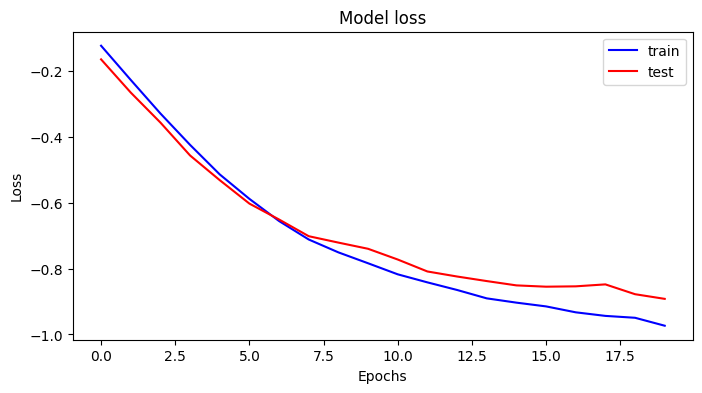

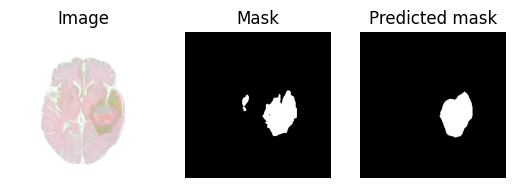

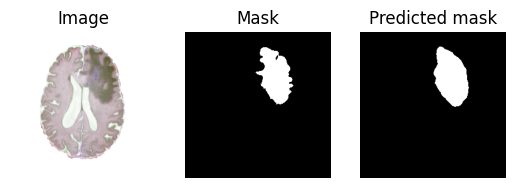

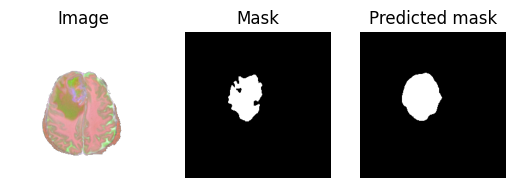

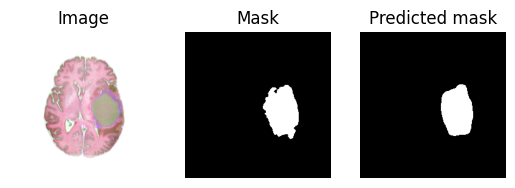

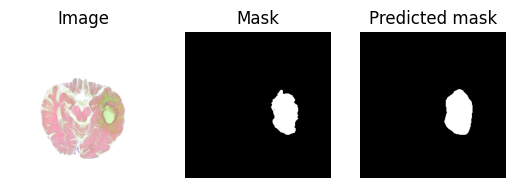

In [ ]:
def plot_original_mask_pred(index, dataset, model, save=False, name=None):
    """
    Plot image and original and predicted masks data side by side from a data set.

    Args:
        index (int): index of the image and mask in the data set.
        dataset (nn.Module): Pytorch Dataset object.
        model (nn.Module): Model to use for predictions.
    """
    image = dataset[index][0]
    mask = dataset[index][1]
    prediction = model.cpu()(dataset[index][0].unsqueeze(0))
    binary_mask = (prediction > 0.5).float()

    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis("off")
    plt.title("Image")
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap="gray")
    plt.axis("off")
    plt.title("Mask")
    plt.subplot(1,3,3)
    plt.imshow(binary_mask.squeeze(), cmap="gray")
    plt.axis("off")
    plt.title("Predicted mask")
    if save:
        if name != None:
            plt.savefig(f"{index}_prediction_{name}.png")
    plt.show()


def plot_loss(history, save=False, name=None):
    """
    Plot training and validation loss history.

    Arg:
        history (pd.DataFrame): Pandas dataframe containing training
            and validation epoch losses.
    """
    train_loss = history["train_loss"]
    val_loss = history["val_loss"]

    plt.figure(figsize=(8,4))
    plt.plot(np.log10(train_loss), color='blue')
    plt.plot(np.log10(val_loss), color='red')
    plt.title("Model loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["train", "test"], loc="upper right")
    if save:
        if name != None:
            plt.savefig(f"loss_history_{name}.png")
    plt.show()

plot_loss(history_deeplab, save=True, name="pretrained")

model_deeplab.eval()

for i in np.random.randint(0, len(val_df), 5):
    plot_original_mask_pred(index=i, dataset=test_df, model=model_deeplab, save=True, name="pretrained")

### Model definition. *Ad-hoc* model
UNet models are a family of fully convolutional arquitectures with encoder-decoder structure, developed for biomedical image segmentation. They are characterized by the use of skip connections, which transfer information from the encoder to the decoder. These connections are the reason of the U shape of this model and for its name.

![Alt Text](https://drive.google.com/uc?id=1CkG9UXzMtIvYprmOeSiiLTadDpPqGGSh)
<center>
<i>Figure 2: UNet model diagram. Image taken from U-Net: Convolutional Networks for Biomedical Image Segmentation. </i>
</center>
The AGResUNet model adds two additional elements to this structure:

* **Residual connections**: Specific of ResNet models. The convolutional blocks of the UNet are replaced by residual blocks, which incorporate the input information directly into the block’s output.
* **Attention gates**: Based on the attention mechanisms from transformers. Attention gates are added during the up-sampling process in the decoder, allowing the network to focus on important regions of the MRI images.

Each component is defined separately in different Python classes and combined in the *AGResUNet* class.

In [ ]:
class ResidualBlock(nn.Module):
    """
    Class for the application of two 2D convolutions, each followed
    by a batch normalization layer and a ReLU layer (in that order)
    with residual connections.

    Args:
        in_ch: Number of input channels.
        out_ch: Number of output channels.

    Returns:
        ResidualBlock (object): Instance of the ResidualBlock class.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv_2d = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding="same"),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding="same"),
            nn.BatchNorm2d(out_ch)
        )
        self.identity_map = nn.Sequential()
        if in_ch != out_ch:
            self.identity_map = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, padding="same"),
                nn.BatchNorm2d(out_ch)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        add = self.double_conv_2d(x) + self.identity_map(x)
        output = self.relu(add)
        return output


class ResDownBlock(nn.Module):
    """
    Class for the construction of a downsampling block that
    returns the skip connection and the downsampled image.

    Args:
        in_ch: Number of input channels.
        out_ch: Number of output channels.

    Returns:
        DownBlock (object): Instance of the DownBlock class.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv_2d = ResidualBlock(in_ch, out_ch)
        self.pooling = nn.MaxPool2d(2, 2)

    def forward(self, x):
        skip = self.double_conv_2d(x)
        x = self.pooling(skip)
        return (x, skip)


class ResUpBlock(nn.Module):
    """
    Class for the construction of a upsampling block that
    returns the skip connection and the upsampled image.

    Args:
        in_ch: Number of input channels.
        out_ch: Number of output channels.

    Returns:
        UpBlock (object): Instance of the UpBlock class.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
        self.double_conv_2d = ResidualBlock(in_ch, out_ch)

    def forward(self, x, skip):
        x = self.conv_transpose(x)
        x = torch.cat([x, skip], dim=1)
        x = self.double_conv_2d(x)
        return x


class AttentionGate(nn.Module):
    """
    Class for the application of the attention gate.

    Args:
        k_ch: Number of key channels.
        g_ch: Number of gate channels.

    Returns:
        AttentionGate (object): Instance of the AttentionGate class.
    """
    def __init__(self, g_ch, k_ch):
        super().__init__()
        self.conv_gate = nn.Conv2d(g_ch, g_ch, 1)
        self.conv_key = nn.Sequential(
            nn.Conv2d(k_ch, k_ch, 1),
            nn.Conv2d(k_ch, g_ch, 2, 2),
        )
        self.attention = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(g_ch, 1, 1),
            nn.Sigmoid(),
            nn.Upsample(scale_factor=2)
        )


    def forward(self, x, g):
        key = self.conv_key(x)
        gate = self.conv_gate(g)
        psi = self.attention(key + gate)
        output = psi * x

        return output



class AGResUNet(nn.Module):
    """
    UNet with residual connections and attention gates. Improvement
    over deep UNet implementations as reduce the problems of vanishing and exploding
    gradients with the residual connections and introduce attention mechanisms
    allowing the network to focus on relevant regions of the images.
    """
    def __init__(self, in_ch = 1, out_classes = 1):
        super().__init__()
        # Encoder
        self.down1 = ResDownBlock(in_ch, 64)
        self.down2 = ResDownBlock(64, 128)
        self.down3 = ResDownBlock(128, 256)
        self.down4 = ResDownBlock(256, 512)
        # Bottleneck
        self.conv = ResidualBlock(512, 1024)
        # Decoder
        self.up1 = ResUpBlock(1024, 512)
        self.up2 = ResUpBlock(512, 256)
        self.up3 = ResUpBlock(256, 128)
        self.up4 = ResUpBlock(128, 64)
        # Attention gates
        self.att1 = AttentionGate(1024, 512)
        self.att2 = AttentionGate(512, 256)
        self.att3 = AttentionGate(256, 128)
        self.att4 = AttentionGate(128, 64)
        # Final convolution
        self.last_conv = nn.Sequential(
            nn.Conv2d(64, out_classes, 1),
            nn.Sigmoid())

    def forward(self, x):
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        x = self.conv(x)
        skip4 = self.att1(skip4, x)
        x = self.up1(x, skip4)
        skip3 = self.att2(skip3, x)
        x = self.up2(x, skip3)
        skip2 = self.att3(skip2, x)
        x = self.up3(x, skip2)
        skip1 = self.att4(skip1, x)
        x = self.up4(x, skip1)
        output = self.last_conv(x)

        return output

Again, once the model is defined, we can proceed with training. The hyperparameters do not change and we use the same training function. However, we change the *minibatch* size due to the computational limitations and the increased complexity of the model.

Starting the training...
Epoch: 1/20


100%|██████████| 100/100 [01:12<00:00,  1.39it/s, loss=0.438]


Epoch training loss: 0.6703869140148163. Epoch validation loss: 0.5879428386688232
Epoch: 2/20


100%|██████████| 100/100 [01:11<00:00,  1.41it/s, loss=0.53]


Epoch training loss: 0.520544040799141. Epoch validation loss: 0.4755163908004761
Epoch: 3/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.223]


Epoch training loss: 0.42678876280784606. Epoch validation loss: 0.4070664715766907
Epoch: 4/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.255]


Epoch training loss: 0.3409804880619049. Epoch validation loss: 0.3079488134384155
Epoch: 5/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.209]


Epoch training loss: 0.273239740729332. Epoch validation loss: 0.25135403394699096
Checkpoint saved
Epoch: 6/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.2]


Epoch training loss: 0.22298762679100037. Epoch validation loss: 0.2063299298286438
Epoch: 7/20


100%|██████████| 100/100 [01:10<00:00,  1.41it/s, loss=0.16]


Epoch training loss: 0.187195103764534. Epoch validation loss: 0.1769607973098755
Epoch: 8/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.172]


Epoch training loss: 0.16519398510456085. Epoch validation loss: 0.1620071840286255
Epoch: 9/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.0942]


Epoch training loss: 0.1439785385131836. Epoch validation loss: 0.138784499168396
Epoch: 10/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.14]


Epoch training loss: 0.13267602622509003. Epoch validation loss: 0.12750263690948485
Checkpoint saved
Epoch: 11/20


100%|██████████| 100/100 [01:11<00:00,  1.40it/s, loss=0.0626]


Epoch training loss: 0.11761389911174774. Epoch validation loss: 0.12062985181808472
Epoch: 12/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.0558]


Epoch training loss: 0.11686212480068207. Epoch validation loss: 0.11202059745788574
Epoch: 13/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.158]


Epoch training loss: 0.10425341010093689. Epoch validation loss: 0.10593756675720215
Epoch: 14/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.0869]


Epoch training loss: 0.09595047831535339. Epoch validation loss: 0.09571627378463746
Epoch: 15/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.0559]


Epoch training loss: 0.08916116416454316. Epoch validation loss: 0.09006325244903564
Checkpoint saved
Epoch: 16/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.0624]


Epoch training loss: 0.08197566747665405. Epoch validation loss: 0.08815706729888916
Epoch: 17/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.0615]


Epoch training loss: 0.08101288080215455. Epoch validation loss: 0.08628142833709716
Epoch: 18/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.05]


Epoch training loss: 0.07956405520439148. Epoch validation loss: 0.08634581089019776
Epoch: 19/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.0884]


Epoch training loss: 0.07869545638561248. Epoch validation loss: 0.08571768283843995
Epoch: 20/20


100%|██████████| 100/100 [01:10<00:00,  1.42it/s, loss=0.086]


Epoch training loss: 0.07990649580955506. Epoch validation loss: 0.08283486366271972
Checkpoint saved
----------------Validation metrics----------------
|  Accuracy: 0.995          Precision: 0.937     |
--------------------------------------------------
|  Recall: 0.937            Dice: 0.916          |
--------------------------------------------------
|  IoU: 0.881                                    |
--------------------------------------------------
...Training done!


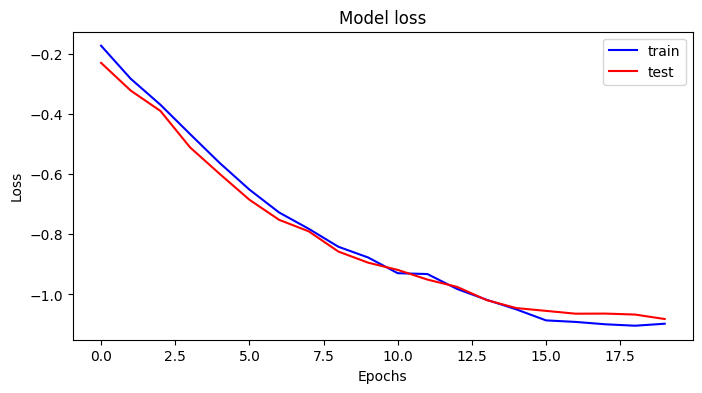

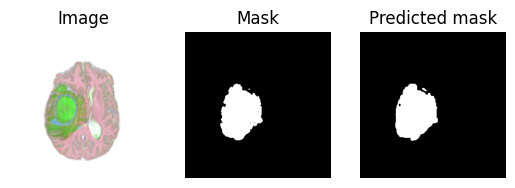

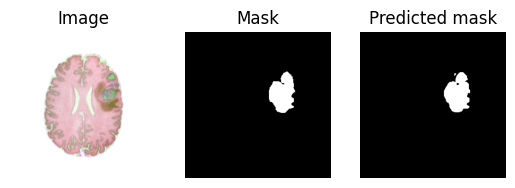

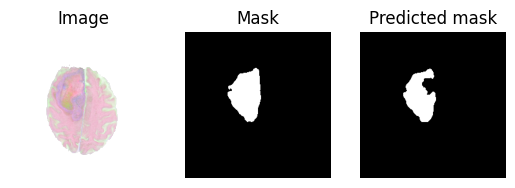

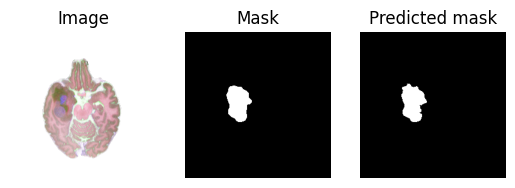

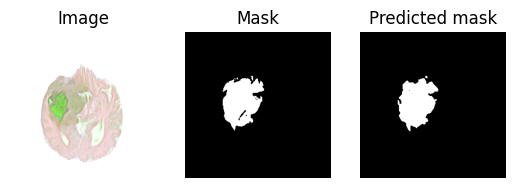

In [ ]:
batch_size = 8
trainloader = DataLoader(train_df, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_df, batch_size=batch_size, shuffle=True)

model_unet = AGResUNet(in_ch=in_ch)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_unet.to(device)

#################### MODEL TRAINING   ####################
# Hyperparameters
epochs = 20
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_unet.parameters(), lr=learning_rate, weight_decay=1e-5)
loss = DiceLossTorch()
history_unet = fit(train_data=trainloader, validation_data=valloader, model=model_unet, loss_fn=loss, optimizer=optimizer,
               epochs=epochs, device=device)
plot_loss(history_unet, save=True, name="unet")

model_unet.eval()

for i in np.random.randint(0, len(val_df), 5):
    plot_original_mask_pred(index=i, dataset=test_df, model=model_unet, save=True, name="unet")